In [1]:
import sys
import pandas as pd
import seaborn as sns
import math
import statistics
import random
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

sys.path.append("..")
from models.MyMetrics import myMSE, myMAPE, myR2, myRMSE, myMAE

In [2]:
data = pd.read_csv(f'../data/trip_duration_task.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 729322 non-null  object 
 1   vendor_id          727135 non-null  float64
 2   pickup_datetime    729322 non-null  object 
 3   dropoff_datetime   729322 non-null  object 
 4   passenger_count    729322 non-null  int64  
 5   pickup_longitude   729322 non-null  float64
 6   pickup_latitude    727475 non-null  float64
 7   dropoff_longitude  729322 non-null  float64
 8   dropoff_latitude   729322 non-null  float64
 9   trip_duration      729322 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 55.6+ MB


In [4]:
data.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,id1080784,2.0,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,400
1,id0889885,1.0,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,1100
2,id0857912,2.0,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,1635
3,id3744273,2.0,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,1141
4,id0232939,1.0,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,848
5,id1918069,2.0,2016-02-14 18:31:42,2016-02-14 18:55:57,2,-73.993614,40.751884,-73.995422,40.723862,1455
6,id2429028,1.0,2016-04-20 20:30:14,2016-04-20 20:36:51,1,-73.965080,40.758915,-73.976807,40.764107,397
7,id1663798,2.0,2016-06-19 16:48:14,2016-06-19 17:06:35,1,-73.963890,40.765434,-73.872429,40.774200,1101
8,id2436943,2.0,2016-03-28 19:17:03,2016-03-28 19:48:29,2,-73.872887,40.774281,-73.979019,40.761879,1886
9,id2933909,1.0,2016-04-10 22:01:41,2016-04-10 22:25:30,1,-73.987823,40.740982,-73.999153,40.686451,1429


## Обработка данных

In [5]:
# Проверим пропуски
data.isna().sum()

id                      0
vendor_id            2187
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
pickup_longitude        0
pickup_latitude      1847
dropoff_longitude       0
dropoff_latitude        0
trip_duration           0
dtype: int64

Понадобится обработка

In [6]:
# vendor_id
data.vendor_id.unique()

array([ 2.,  1., nan])

In [7]:
data['vendor_id'].value_counts()

vendor_id
2.0    389291
1.0    337844
Name: count, dtype: int64

In [8]:
for i in range(len(data['vendor_id'])):
    if math.isnan(data['vendor_id'].loc[data.index[i]]):
        data['vendor_id'].loc[data.index[i]] = random.choice([1.0, 2.0])

In [9]:
# pickup_latitude 
list = []
for i in range(len(data['pickup_latitude'])):
    list.append(data['pickup_latitude'].loc[data.index[i]] - data['dropoff_latitude'].loc[data.index[i]])

In [12]:
for i in range(len(list)-1):
    if math.isnan(list[i]):
        del list[i]
        i-=1
mean = sum(list)/len(list)
print(mean)

-0.0008561123804995453


In [13]:
for i in range(len(data['pickup_latitude'])):
    if math.isnan(data['pickup_latitude'].loc[data.index[i]]):
        data['pickup_latitude'].loc[data.index[i]] = data['dropoff_latitude'].loc[data.index[i]] + mean

In [14]:
data.isna().sum()

id                   0
vendor_id            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
trip_duration        0
dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 729322 non-null  object 
 1   vendor_id          729322 non-null  float64
 2   pickup_datetime    729322 non-null  object 
 3   dropoff_datetime   729322 non-null  object 
 4   passenger_count    729322 non-null  int64  
 5   pickup_longitude   729322 non-null  float64
 6   pickup_latitude    729322 non-null  float64
 7   dropoff_longitude  729322 non-null  float64
 8   dropoff_latitude   729322 non-null  float64
 9   trip_duration      729322 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 55.6+ MB


In [16]:
data[['pickup_datetime', '1']] = data['pickup_datetime']. str.split(' ',  expand= True ) 
data[['dropoff_datetime', '2']] = data['dropoff_datetime']. str.split(' ',  expand= True ) 

In [17]:
data.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,1,2
0,id1080784,2.0,2016-02-29,2016-02-29,1,-73.953918,40.778873,-73.963875,40.771164,400,16:40:21,16:47:01
1,id0889885,1.0,2016-03-11,2016-03-11,2,-73.988312,40.731743,-73.994751,40.694931,1100,23:35:37,23:53:57
2,id0857912,2.0,2016-02-21,2016-02-21,2,-73.997314,40.721458,-73.948029,40.774918,1635,17:59:33,18:26:48
3,id3744273,2.0,2016-01-05,2016-01-05,6,-73.961670,40.759720,-73.956779,40.780628,1141,09:44:31,10:03:32
4,id0232939,1.0,2016-02-17,2016-02-17,1,-74.017120,40.708469,-73.988182,40.740631,848,06:42:23,06:56:31
5,id1918069,2.0,2016-02-14,2016-02-14,2,-73.993614,40.751884,-73.995422,40.723862,1455,18:31:42,18:55:57
6,id2429028,1.0,2016-04-20,2016-04-20,1,-73.965080,40.758915,-73.976807,40.764107,397,20:30:14,20:36:51
7,id1663798,2.0,2016-06-19,2016-06-19,1,-73.963890,40.765434,-73.872429,40.774200,1101,16:48:14,17:06:35
8,id2436943,2.0,2016-03-28,2016-03-28,2,-73.872887,40.774281,-73.979019,40.761879,1886,19:17:03,19:48:29
9,id2933909,1.0,2016-04-10,2016-04-10,1,-73.987823,40.740982,-73.999153,40.686451,1429,22:01:41,22:25:30


In [18]:
data.pop('pickup_datetime')
data.pop('dropoff_datetime')

0         2016-02-29
1         2016-03-11
2         2016-02-21
3         2016-01-05
4         2016-02-17
             ...    
729317    2016-05-21
729318    2016-02-22
729319    2016-04-15
729320    2016-06-19
729321    2016-01-01
Name: dropoff_datetime, Length: 729322, dtype: object

In [19]:
data = data.rename(columns = {'1' : 'pickup_datetime', '2': 'dropoff_datetime'})

In [20]:
# Поменяем типы столбцов
data['vendor_id'] = data['vendor_id'].astype(int)

data['pickup_datetime'] = data['pickup_datetime'].astype('datetime64[ns]')
data['dropoff_datetime'] = data['dropoff_datetime'].astype('datetime64[ns]')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 729322 non-null  object        
 1   vendor_id          729322 non-null  int32         
 2   passenger_count    729322 non-null  int64         
 3   pickup_longitude   729322 non-null  float64       
 4   pickup_latitude    729322 non-null  float64       
 5   dropoff_longitude  729322 non-null  float64       
 6   dropoff_latitude   729322 non-null  float64       
 7   trip_duration      729322 non-null  int64         
 8   pickup_datetime    729322 non-null  datetime64[ns]
 9   dropoff_datetime   729322 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int32(1), int64(2), object(1)
memory usage: 52.9+ MB


## EDA

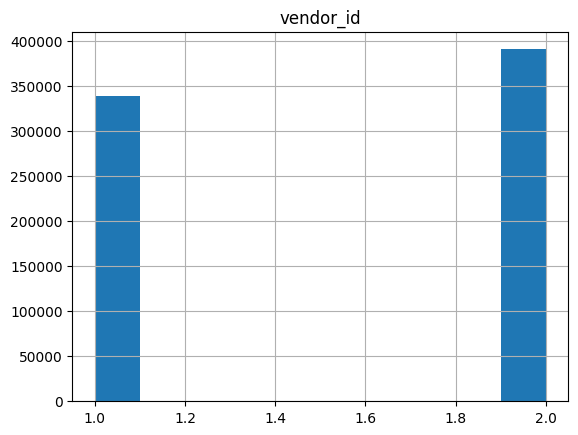

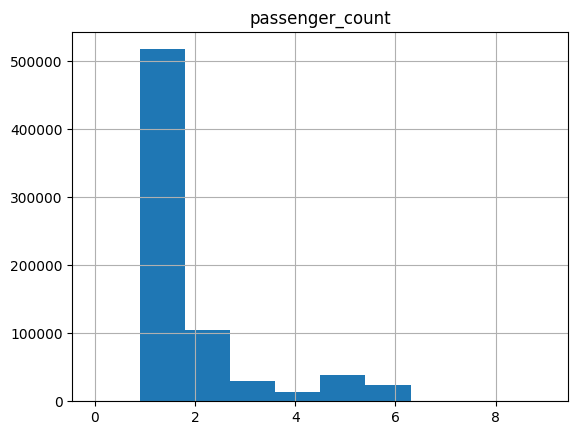

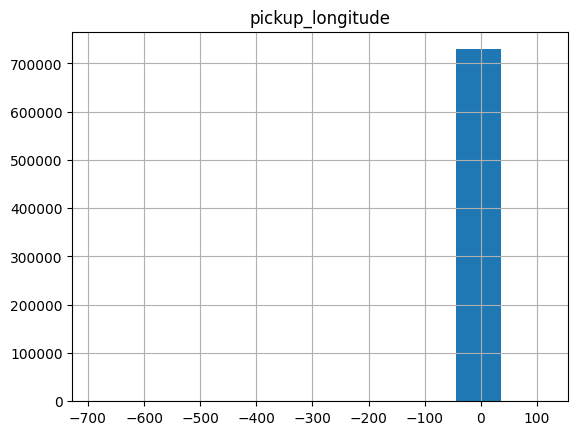

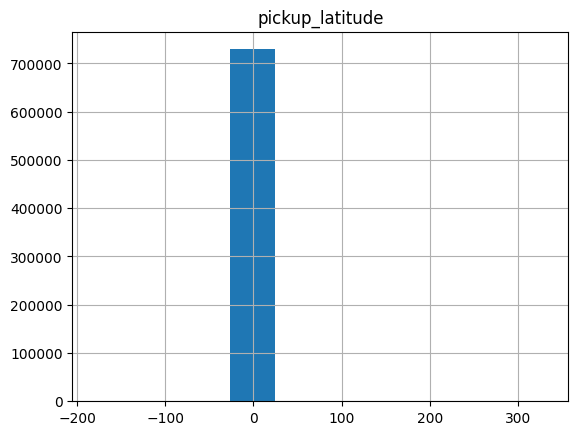

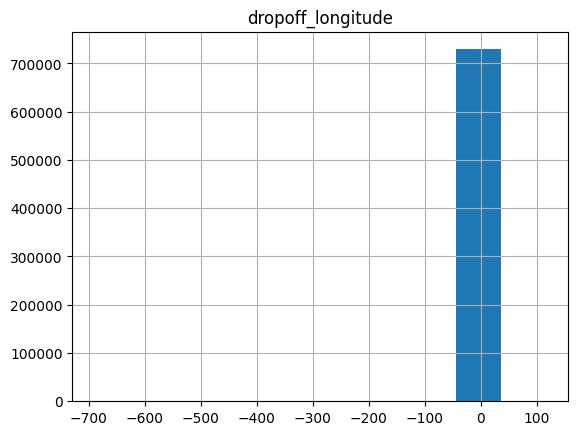

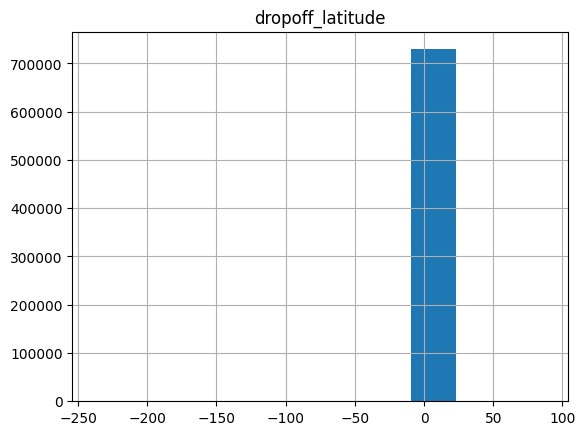

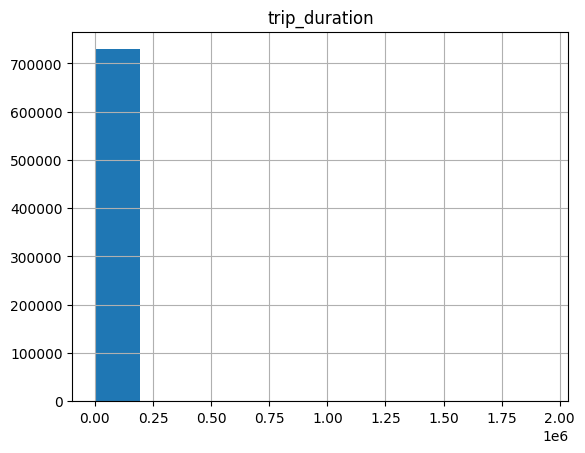

In [59]:
data1 =data
data1 = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] = (data1-data1.mean())/data1. std()
data1 = data

data1 = data1.drop(['id'], axis=1)
data1 = data1.drop(['pickup_datetime'], axis=1)
data1 = data1.drop(['dropoff_datetime'], axis=1)
columns = data1.columns.to_list()

for column in columns:
    data1.hist(column, bins = 10)

## Разделение выборок
Отделим целевой признак от данных, разделим полученные датасеты на тренировочные и тестовые выборки

In [60]:
y = data1['trip_duration']
X = data1.drop(['trip_duration'], axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [62]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((583457, 6), (583457,), (145865, 6), (145865,))

## Составим Регрессии


Линейная регрессия

<Axes: >

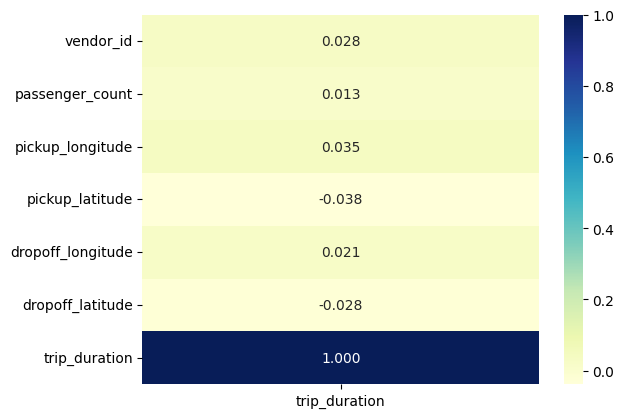

In [63]:
corr_matrix = data1.corr()
sns.heatmap(corr_matrix[['trip_duration']], annot=True, cmap="YlGnBu", fmt=".3f")

Наиболее подходящими являются столбец pickup_longitude

In [64]:
train_lr = X_train['pickup_latitude'].values.reshape(-1,1)
test_lr = X_test['pickup_latitude'].values.reshape(-1,1)

lr = LinearRegression().fit(train_lr, y_train)
y_predict = lr.predict(test_lr)

In [65]:
# Вес предиктора
lr.coef_

array([-151.31483049])

In [66]:
## Создадим функцию для вывода ошибок
def Errors(y_test, y_predict):
    MAE = mean_absolute_error(y_test, y_predict)
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = sqrt(mean_squared_error(y_test, y_predict))
    MAPE = sqrt(mean_absolute_percentage_error(y_test, y_predict))
    R2 = r2_score(y_test, y_predict)

    return  {'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE, 'MAPE': MAPE, 'R2': R2} 

def MyErrors(y_test, y_predict):
    mMAE = myMAE(y_test, y_predict)
    mMSE = myMSE(y_test, y_predict)
    mRMSE = myRMSE(y_test, y_predict)
    mMAPE = myMAPE(y_test, y_predict)
    mR2 = myR2(y_test, y_predict)

    return  {'myMAE': mMAE, 'myMSE': mMSE, 'myRMSE': mRMSE, 'myMAPE': mMAPE, 'myR2': mR2} 

In [67]:
# Ошибки 
errors_lr = Errors(y_test, y_predict)
print(Errors(y_test, y_predict))
print(MyErrors(y_test, y_predict))

{'MAE': 611.5568312262694, 'MSE': 10157405.22576554, 'RMSE': 3187.0684375716723, 'MAPE': 1.2583492203511681, 'R2': 0.0017067412773691393}
{'myMAE': 611.556831226262, 'myMSE': 10157405.225765565, 'myRMSE': 3187.0684375716764, 'myMAPE': 1.5834427603584025, 'myR2': 0.001706741277362589}


## Ridge

In [68]:
## Найдем параметр для регуляризации сеткой
r_parameters = {'alpha': np.arange(0.01, 1, 0.1)}

In [69]:
best_ridge = GridSearchCV(Ridge(), r_parameters).fit(train_lr, y_train)
best_ridge.best_params_

{'alpha': 0.91}

Оптимальный параметр - 0.91

Обучим данную модель учитывая Ridge

In [70]:
ridge_lr = Ridge(alpha=0.91).fit(X_train[['pickup_latitude']], y_train)
y_predict_ridge = ridge_lr.predict(X_test[['pickup_latitude']])

In [71]:
errors_ridge_lr = Errors(y_test, y_predict_ridge)
print(errors_ridge_lr)
print(MyErrors(y_test, y_predict_ridge))

{'MAE': 611.556835503133, 'MSE': 10157405.21642986, 'RMSE': 3187.0684361070535, 'MAPE': 1.258349208553544, 'R2': 0.0017067421949013006}
{'myMAE': 611.556835503126, 'myMSE': 10157405.216429751, 'myRMSE': 3187.0684361070366, 'myMAPE': 1.5834427306673198, 'myR2': 0.001706742194907962}


In [72]:
ridge_lr.coef_

array([-151.31459338])

## Lasso

In [73]:
# Массив допустимых параметров
l_parameters = {'alpha': np.arange(0.01, 1, 0.1)}

Обучим данную модель учитывая Lasso

In [74]:
best_lasso = GridSearchCV(Lasso(), l_parameters).fit(train_lr, y_train)
best_lasso.best_params_

{'alpha': 0.91}

In [75]:
lasso_lr = Ridge(alpha=0.91).fit(X_train[['pickup_latitude']], y_train)
y_predict_lasso = lasso_lr.predict(X_test[['pickup_latitude']])

In [76]:
errors_lasso_lr = Errors(y_test,  y_predict_lasso)
print(errors_lasso_lr)
print(MyErrors(y_test,  y_predict_lasso))

{'MAE': 611.556835503133, 'MSE': 10157405.21642986, 'RMSE': 3187.0684361070535, 'MAPE': 1.258349208553544, 'R2': 0.0017067421949013006}
{'myMAE': 611.556835503126, 'myMSE': 10157405.216429751, 'myRMSE': 3187.0684361070366, 'myMAPE': 1.5834427306673198, 'myR2': 0.001706742194907962}


In [77]:
lasso_lr.coef_

array([-151.31459338])

## Elastic Net

In [78]:
elastic_lr = ElasticNet(alpha=10, l1_ratio=0.1).fit(X_train[['pickup_latitude']], y_train)
y_predict_elastic = elastic_lr.predict(X_test[['pickup_latitude']])

In [79]:
errors_elastic_lr = Errors(y_test, y_predict_elastic)
print(errors_elastic_lr)
print(MyErrors(y_test, y_predict_elastic))

{'MAE': 619.5375092597887, 'MSE': 10170977.831368877, 'RMSE': 3189.197051197821, 'MAPE': 1.2571633706338732, 'R2': 0.00037279423322222893}
{'myMAE': 619.5375092597833, 'myMSE': 10170977.831368778, 'myRMSE': 3189.1970511978056, 'myMAPE': 1.5804597404635272, 'myR2': 0.0003727942332280021}


In [80]:
elastic_lr.coef_

array([-14.96725247])

## Заключение


Сравнивая полученные результаты, делаем вывод что наилучшая модель обучения среди данных - это Elastic Net, хотя значения практически не отличаются друг от друга.

## Масштабирование


In [81]:
scaler = StandardScaler()

In [82]:
scaler.fit(X_train)

StandardScaler()

In [83]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Множественная линейнаяя регрессия

In [84]:
mlr = LinearRegression().fit(X_train, y_train)
y_pred = mlr.predict(X_test)


In [85]:
errors_mlr = Errors(y_test, y_pred)
print(errors_mlr)
print(MyErrors(y_test, y_pred))

{'MAE': 601.412036414592, 'MSE': 10121486.721825598, 'RMSE': 3181.42840903667, 'MAPE': 1.2591860529546708, 'R2': 0.005236894850024543}
{'myMAE': 601.4120364145874, 'myMSE': 10121486.72182554, 'myRMSE': 3181.428409036661, 'myMAPE': 1.5855495159555708, 'myR2': 0.00523689485002643}


In [86]:
mlr.coef_

array([  99.01992483,   19.8525486 ,  183.83636914, -121.30384697,
        -47.20298135,  -76.5120972 ])

## Ridge

In [87]:
r_parameters = {'alpha': np.arange(0, 1, 0.1)}

best_ridge = GridSearchCV(Ridge(), r_parameters).fit(X_train, y_train)
best_ridge.best_params_

{'alpha': 0.9}

In [88]:
ridge_mlr = Ridge(alpha=0.91).fit(X_train, y_train)
y_predict_ridge = ridge_mlr.predict(X_test)

In [89]:
ridge_mlr.coef_

array([  99.01977123,   19.85256345,  183.83535953, -121.30373279,
        -47.20210751,  -76.51205014])

In [90]:
errors_ridge_mlr = Errors(y_test, y_predict_ridge)
print(errors_ridge_mlr)
print(MyErrors(y_test, y_predict_ridge))

{'MAE': 601.4120268480416, 'MSE': 10121486.711513111, 'RMSE': 3181.428407415938, 'MAPE': 1.2591860371728878, 'R2': 0.005236895863559465}
{'myMAE': 601.4120268480357, 'myMSE': 10121486.711512923, 'myRMSE': 3181.4284074159086, 'myMAPE': 1.585549476211166, 'myR2': 0.00523689586357412}


Наблюдаем изменение значений

## Lasso

In [91]:
best_lasso = GridSearchCV(Lasso(), l_parameters).fit(X_train, y_train)
best_lasso.best_params_

{'alpha': 0.91}

In [120]:
lasso_mlr = Lasso(alpha=0.91).fit(X_train, y_train)
y_predict_lasso = lasso_mlr.predict(X_test)

In [121]:
errors_lasso_mlr = Errors(y_test, y_predict_lasso)
print(errors_lasso_mlr)
print(MyErrors(y_test, y_predict_lasso))

{'MAE': 601.2961146156323, 'MSE': 10121337.791499998, 'RMSE': 3181.4050027464277, 'MAPE': 1.259152185172724, 'R2': 0.005251532066593345}
{'myMAE': 601.2961146156266, 'myMSE': 10121337.791500036, 'myRMSE': 3181.4050027464336, 'myMAPE': 1.5854642254252174, 'myR2': 0.005251532066585796}


In [122]:
lasso_mlr.coef_

array([  98.33316925,   19.14850342,  178.98902293, -120.98004545,
        -42.48038014,  -75.94089518])

## ElasticNet

In [95]:
elastic_model = ElasticNet(max_iter=100000)
elastic_parametrs = {'alpha':[0.1,1,10,100],'l1_ratio':[0.1,0.75,0.99,1]}
best_elastic = GridSearchCV(elastic_model, param_grid=elastic_parametrs,scoring = 'neg_mean_squared_error')
best_elastic.fit(X_train, y_train)
best_elastic.best_params_

{'alpha': 1, 'l1_ratio': 0.1}

In [97]:
elastic_mlr = ElasticNet(alpha=1, l1_ratio=0.1).fit(X_train, y_train)
y_predict_elastic = elastic_mlr.predict(X_test)

In [98]:
errors_elastic_mlr = Errors(y_test, y_predict_elastic)
print(errors_elastic_mlr)
print(MyErrors(y_test, y_predict_elastic))

{'MAE': 604.9015862366848, 'MSE': 10131359.819407523, 'RMSE': 3182.9797076650557, 'MAPE': 1.2556584914646447, 'R2': 0.004266544003556083}
{'myMAE': 604.9015862366767, 'myMSE': 10131359.81940757, 'myRMSE': 3182.979707665063, 'myMAPE': 1.5766782471872753, 'myR2': 0.004266544003547534}


In [99]:
elastic_mlr.coef_

array([ 52.64607207,  17.62319152,  64.63978448, -70.9328457 ,
        20.55664847, -50.177863  ])

Наиулчшей моделью оказалась модель Lasso, модель ElasticNet очень близка к ней по всем поазателям

## Полиномиальная регрессия

In [100]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', LinearRegression())] 

In [101]:
pipe = Pipeline(Input)
pipe

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [102]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [103]:
y_predict = pipe.predict(X_test)

In [104]:
errors_plr = Errors(y_test, y_predict)
print(errors_plr)
print(MyErrors(y_test, y_predict))

{'MAE': 571.5057597774173, 'MSE': 56861182.609749496, 'RMSE': 7540.635424800054, 'MAPE': 1.2084809218374624, 'R2': -4.588448429557583}
{'myMAE': 571.5057597774173, 'myMSE': 56861182.60974987, 'myRMSE': 7540.635424800079, 'myMAPE': 1.4604261384451103, 'myR2': -4.5884484295576415}


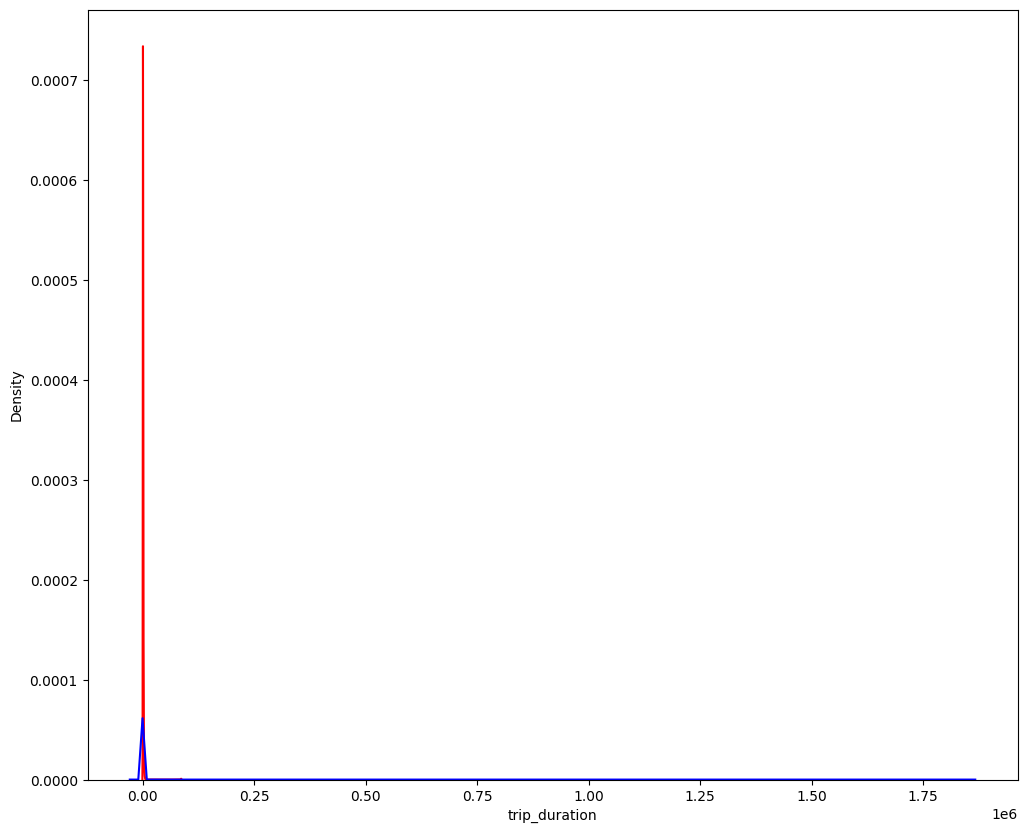

In [105]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
sns.distplot(y_predict, hist=False, color='Blue', label='Predicted values')
plt.show()

Наблюдаем, что в целом модель неплохо предсказывает значения, однако отклонения все же имеются

## Ridge

In [106]:
Input = [('standardscaler', StandardScaler()), ('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Ridge(alpha=0.9))]
pipe_ridge = Pipeline(Input)
pipe_ridge.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', Ridge(alpha=0.9))])

In [107]:
y_predict_ridge = pipe_ridge.predict(X_test)
y_predict_ridge

array([ 766.50322708,  696.24728475,  829.56190267, ...,  649.28623117,
        771.91051677, 1212.19223695])

In [108]:
errors_ridge_plr = Errors(y_test, y_predict_ridge)
print(errors_ridge_plr)
print(MyErrors(y_test, y_predict_ridge))

{'MAE': 571.5036736826967, 'MSE': 56860995.107285, 'RMSE': 7540.622991987134, 'MAPE': 1.2084759983542557, 'R2': -4.588430001382066}
{'myMAE': 571.5036736826925, 'myMSE': 56860995.10728479, 'myRMSE': 7540.62299198712, 'myMAPE': 1.4604142385983079, 'myR2': -4.588430001382067}


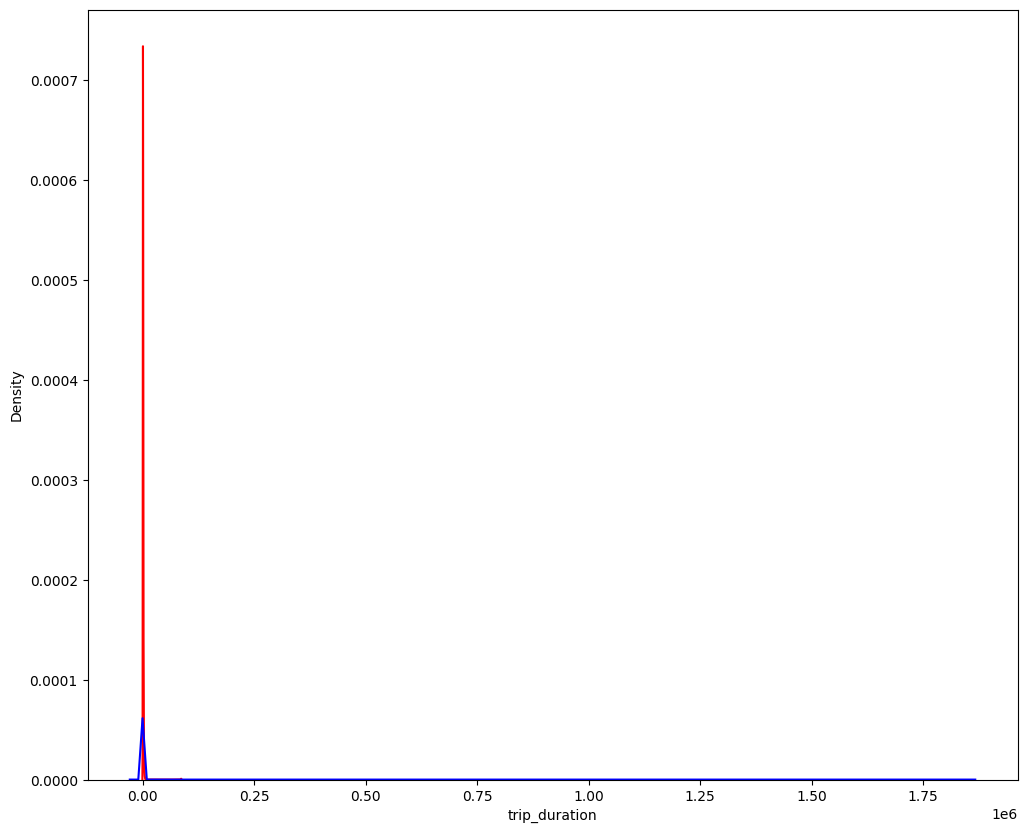

In [109]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
sns.distplot(y_predict_ridge, hist=False, color='Blue', label='Predicted values')
plt.show()

Показатели практически не изменились

## Lasso

In [111]:
Input = [('standardscaler', StandardScaler()), ('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Lasso(alpha=0.01))]
pipe_lasso = Pipeline(Input)
pipe_lasso.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', Lasso(alpha=0.01))])

In [112]:
y_predict_lasso = pipe_lasso.predict(X_test)
y_predict_lasso

array([ 778.8027123 ,  687.16991532,  767.52000225, ...,  606.9592997 ,
        825.77263525, 1147.22213643])

In [113]:
errors_lasso_plr = Errors(y_test, y_predict_lasso)
print(errors_lasso_plr)
print(MyErrors(y_test, y_predict_lasso))

{'MAE': 571.4890744184139, 'MSE': 27040295.767122228, 'RMSE': 5200.028439068601, 'MAPE': 1.2547016976622285, 'R2': -1.6575827564415917}
{'myMAE': 571.4890744184072, 'myMSE': 27040295.767121878, 'myRMSE': 5200.028439068567, 'myMAPE': 1.5742763501164885, 'myR2': -1.6575827564415682}


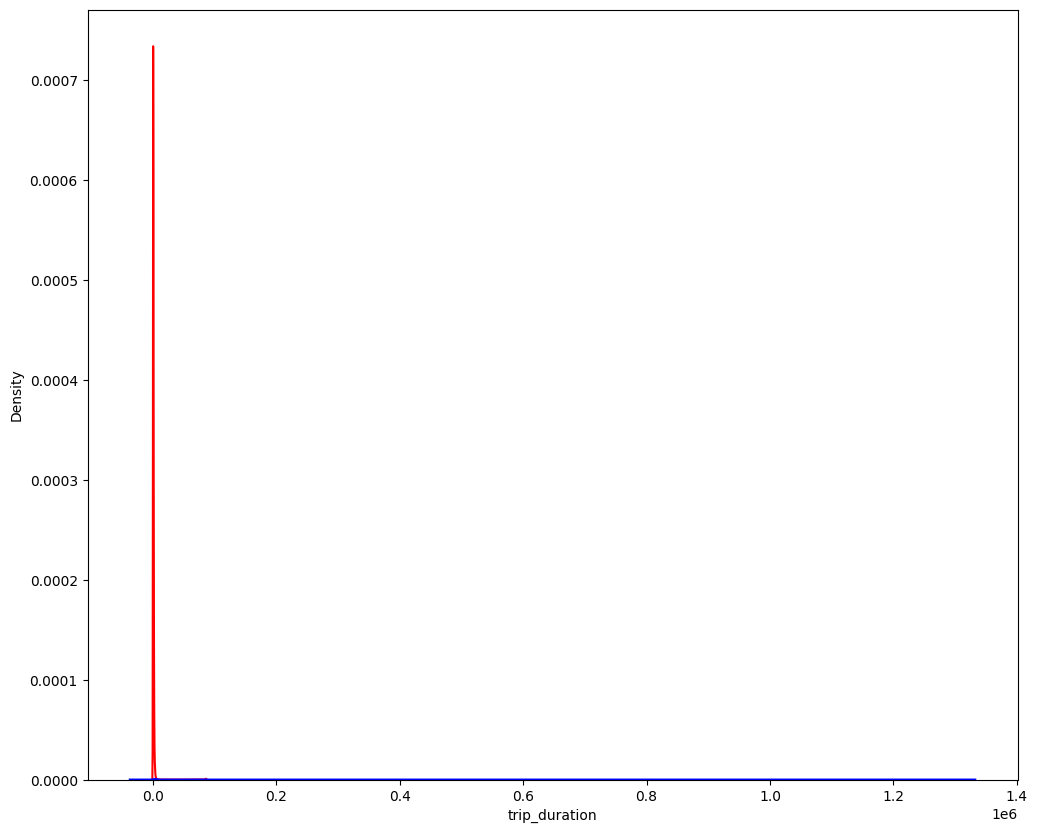

In [114]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
sns.distplot(y_predict_lasso, hist=False, color='Blue', label='Predicted values')
plt.show()

Показатели также практически не изменились

## Elactic Net

In [115]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', ElasticNet(alpha=0.1, l1_ratio=0.1))]
pipe_elastic = Pipeline(Input)
pipe_elastic.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', ElasticNet(alpha=0.1, l1_ratio=0.1))])

In [116]:
y_predict_elastic = pipe_elastic.predict(X_test)
y_predict_elastic

array([ 786.84258981,  713.43846596,  798.09339359, ...,  649.5767399 ,
        850.66566903, 1147.4951818 ])

In [117]:
errors_elastic_plr = Errors(y_test, y_predict_elastic)
print(errors_elastic_plr)
print(MyErrors(y_test, y_predict_elastic))

{'MAE': 573.3318455765907, 'MSE': 25547874.681007784, 'RMSE': 5054.490546138926, 'MAPE': 1.2486357811062914, 'R2': -1.510904163205565}
{'myMAE': 573.3318455765981, 'myMSE': 25547874.68100789, 'myRMSE': 5054.490546138937, 'myMAPE': 1.5590913138589286, 'myR2': -1.5109041632055855}


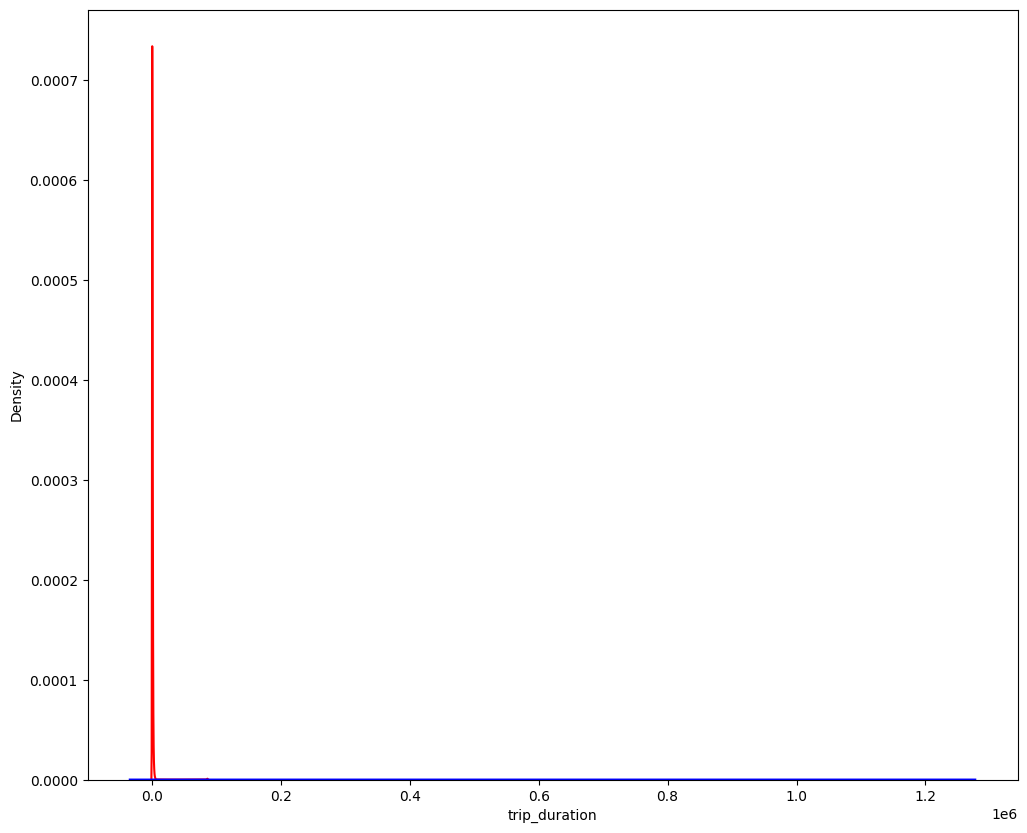

In [118]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
sns.distplot(y_predict_elastic, hist=False, color='Blue', label='Predicted values')
plt.show()

Видими небольшое изменение показателей

Наилучшей моделью можно считать Lasso

## Выбор лучшей модели

In [119]:
print(errors_elastic_lr)
print(errors_lasso_mlr)
print(errors_elastic_plr)

{'MAE': 619.5375092597887, 'MSE': 10170977.831368877, 'RMSE': 3189.197051197821, 'MAPE': 1.2571633706338732, 'R2': 0.00037279423322222893}
{'MAE': 601.410719036983, 'MSE': 10121484.963425085, 'RMSE': 3181.428132682724, 'MAPE': 1.2591856640455086, 'R2': 0.005237067669690565}
{'MAE': 573.3318455765907, 'MSE': 25547874.681007784, 'RMSE': 5054.490546138926, 'MAPE': 1.2486357811062914, 'R2': -1.510904163205565}


## Учитывая полученные результаты, можно сказать, что наилучшей моделью среди рассмотренных можно считать множественную линейную регрессию.